# Setup

In [4]:
# Library Import
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load Data

In [413]:
# Get path to data storage
path = os.getcwd().split('pricing_wizards/')[0] + 'pricing_wizards/data/post_preprocessing_without_dummies.csv'

# Load data
df  = pd.read_csv(path)

In [410]:
# Ensure data is loaded correctly
data.sample(5)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized
186449,31218979,2023-10-19,2555515,895,895,9,76,Clarks,"New, still with price",Grey,Men,Men,Men,Sneakers,0.924126,0.050346,0.093612,0.117568,0.006997,0.029316
252017,30527866,2023-09-16,2140792,376,376,17,199,Stussy,"New, still with price",Black,Men,Men,Clothes,Hoodies,-0.078529,1.220111,0.809513,0.048230,0.018321,0.055375
166967,31138955,2023-10-15,2056875,242,299,16,191,Nike,Good but used,NaN,Men,Men,Clothes,T-shirts,-0.337403,1.144028,0.720025,0.030327,0.017584,0.052117
204286,31504188,2023-11-03,1951234,185,185,3,18,NaN,Almost as new,Black,Women,Women,Clothes,Dresses,-0.447521,-0.501250,-0.443314,0.022712,0.001657,0.009772
74570,31517424,2023-11-04,2493226,3400,3200,7,66,Louis Vuitton,Good but used,NaN,Women,Women,Women,Rygsække,5.763528,-0.044757,-0.085363,0.452238,0.006076,0.022801


# Outlier Detection

There are many different ways to do this, some of the approaches used below are:
* General outlier exploration: Here we just look into the data to and see if their are any values that lie significantly further away from others
* IQR (Interquartile Range): A basic statistcal method for detecting outliers. Not particularly sofisticated, but efficent. $Q_1 - 1.5*(Q_3-Q_1) < x < Q_3 + 1.5*(Q_3-Q_1)$

### General Outlier Exploration

In [414]:
# Listing price distribution
percentiles = [.25, .5, .75, .8, .9, .99, .999]
df.listing_price.describe(percentiles=percentiles)

count    286570.000000
mean        453.937872
std         612.100921
min           1.000000
25%         150.000000
50%         299.000000
75%         539.750000
80%         650.000000
90%        1000.000000
99%        2600.000000
99.9%      6000.000000
max      100000.000000
Name: listing_price, dtype: float64

In [415]:
# 99% of listing prices are equal to or below 2600. 99.9% are below 6000, implying those above are very rare instaces

In [416]:
# Looking into 6k+ listings
df[df.listing_price >= 6000].subsubsubcategory_name.value_counts()

Crossbody bags         51
Jackets                51
Shoulder bags          45
Tasker                 21
Sneakers               18
iPhones                13
Håndtasker             12
Boots                   9
Men                     7
Computere               6
Weekend bags            5
Women                   5
Shoes                   5
Rygsække                4
Coats                   4
Sweatshirts             3
Totebags                3
Sandals                 3
Flats                   3
Waist bags              3
Waistcoats              2
Electronics             2
Øreringe                2
Down jackets            2
Trench coats            2
Fur coats               2
Outerwear               1
Clothes                 1
Belts                   1
Hoodies                 1
Ringe                   1
Pendants & parts        1
Overtøj                 1
Table sets              1
Other jewelry           1
Shoes & boots           1
Leather jackets         1
Other accessories       1
Punge       

In [417]:
df[df.listing_price >= 6000].brand_name.value_counts()

Louis Vuitton         53
Moncler               29
Prada                 20
Gucci                 20
Marni                 17
Mulberry              15
Apple                 12
Bottega Veneta        12
Chanel                11
Nike                   8
Balenciaga             7
Acne Studios           7
Céline                 6
Dior                   6
Air Jordan             6
Yves Saint Laurent     5
Jordan                 5
Canada Goose           5
Saks Potts             5
Hermès                 3
AF Agger               3
Travis Scott           3
Stone Island           3
Christian Dior         3
Valentino              2
Burberry               2
Arc'teryx              2
Adidas                 2
The North Face         2
Maison Margiela        2
One Vintage            1
Royal Copenhagen       1
66 North               1
Nike Sb                1
Vintage                1
Proenza Schouler       1
Iglo                   1
Tom Ford               1
Venderbys              1
Stussy                 1


In [418]:
# Maybe not very surprisingly, the most frequent subsubsub-categories and brands for these listings are often expensive. However, due to their relatively low frequency in the dataset, 
# it's likely that the models will struggle with such listings

In [419]:
expensive_brands = ['Louis Vuitton', 'Moncler', 'Prada', 'Gucci', 'Marni', 'Mulberry', 'Apple', 'Bottega Veneta', 'Chanel']
df[df.brand_name.isin(expensive_brands)].listing_price.describe(percentiles=percentiles)

count     7518.000000
mean      1475.810189
std       1527.837266
min          2.000000
25%        400.000000
50%        900.000000
75%       2000.000000
80%       2300.000000
90%       3500.000000
99%       7000.000000
99.9%     9741.500000
max      13250.000000
Name: listing_price, dtype: float64

<Axes: xlabel='listing_price', ylabel='Proportion'>

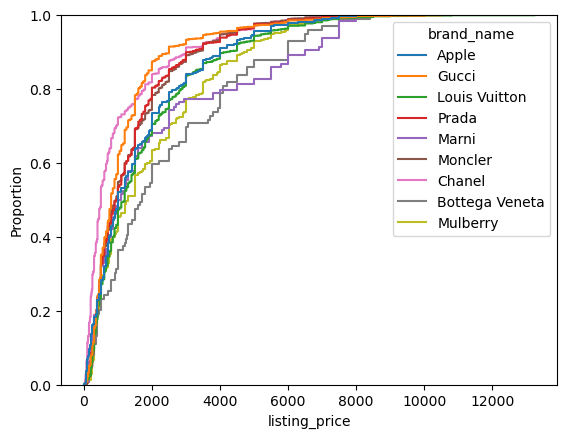

In [420]:
# Survival plot for top-brands
sns.ecdfplot(data= df[df.brand_name.isin(expensive_brands)], x='listing_price',hue='brand_name')

In [421]:
# Looking into a survival/proportion plot, we see that the great majority of listings from these products are below 6k. Amongst the brands listed, a few (Marni, Bottege Veneta, Mulberry) seems to be slightly more 
# expensive with regards to listing price as their curve is more flat, however, this is nothing significant and could be a result of fewer postings for these niche brands

### IQR (Interquartile Range)
Basic statistcal method for detecting outliers. Not particularly sofisticated, but efficent. For this task however, we'd are dealing with speciality items as well which are likely outliers when computed in such a light
$$Q_1 - 1.5*(Q_3-Q_1) < x < Q_3 + 1.5*(Q_3-Q_1)$$

In [422]:
# Listing price quantiles and thresholds
q_1 = df.listing_price.quantile(.25)
q_3 = df.listing_price.quantile(.75)
lower_bound = q_1 - 1.5*(q_3-q_1)
upper_bound = q_3 + 1.5*(q_3-q_1)

# Detection function
outlier = lambda x: True if x < lower_bound or x > upper_bound else False

# Computing outlier
df['outlier'] = df.listing_price.apply(outlier)

In [423]:
# Percentage of dataframe that is outlier
str(round(df[df.outlier == True].shape[0]/df.shape[0]*100, 2)) + '%'

'8.49%'

In [424]:
# Listing price description
df[df.outlier == True].listing_price.describe(percentiles=percentiles)

count     24342.000000
mean       1846.415290
std        1270.490832
min        1125.000000
25%        1295.000000
50%        1500.000000
75%        1995.000000
80%        2000.000000
90%        2900.000000
99%        6000.000000
99.9%      9000.000000
max      100000.000000
Name: listing_price, dtype: float64

#### IQR on a brandlevel

In [425]:
# Computing qunatiles on brandlevel
iqr_brand = df.groupby('brand_name').agg(q25 = ('listing_price', lambda x: x.quantile(.25)),
                                         q75 = ('listing_price', lambda x: x.quantile(.75))).reset_index()

# Computing difference and thresholds
iqr_brand = iqr_brand.assign(
    difference = lambda x: x.q75 - x.q25,
    upper_bound = lambda x: x.q75 + 2*(x.difference),
    lower_bound = lambda x: x.q25 - 2*(x.difference))



# Merging with dataframe
iqr_df = df.copy()
iqr_df = iqr_df[['classified_id','listing_price','brand_name']].merge(iqr_brand, on='brand_name',how='left')

# Detecting outliers
df['outlier_brand_level'] = (iqr_df.listing_price > iqr_df.upper_bound) | (iqr_df.listing_price < iqr_df.lower_bound)
iqr_df['outlier'] = (iqr_df.listing_price > iqr_df.upper_bound) | (iqr_df.listing_price < iqr_df.lower_bound)

In [426]:
# Evaluating bounds of expensive brands
iqr_brand[iqr_brand.brand_name.isin(expensive_brands)]

,brand_name,q25,q75,difference,upper_bound,lower_bound
21,Apple,500.00,2200.0,1700.00,5600.0,-2900.00
48,Bottega Veneta,750.00,3975.0,3225.00,10425.0,-5700.00
71,Chanel,226.25,1337.5,1111.25,3560.0,-1996.25
142,Gucci,450.00,1500.0,1050.00,3600.0,-1650.00
217,Louis Vuitton,500.00,2500.0,2000.00,6500.0,-3500.00
235,Marni,450.00,2662.5,2212.50,7087.5,-3975.00
245,Moncler,450.00,2000.0,1550.00,5100.0,-2650.00
251,Mulberry,500.00,3000.0,2500.00,8000.0,-4500.00
312,Prada,450.00,1800.0,1350.00,4500.0,-2250.00


In [427]:
# As identified earlier, Bottege Venta, Marni and Mulberry have higher upper bounds.

In [428]:
# General statistics for outliers
df[df.outlier_brand_level == True].listing_price.describe(percentiles=percentiles)

count      6868.000000
mean       1728.796010
std        2129.852082
min          10.000000
25%         750.000000
50%        1295.000000
75%        2000.000000
80%        2300.000000
90%        3500.000000
99%        7500.000000
99.9%     10539.900000
max      100000.000000
Name: listing_price, dtype: float64

<Axes: xlabel='listing_price', ylabel='subsubsubcategory_name'>

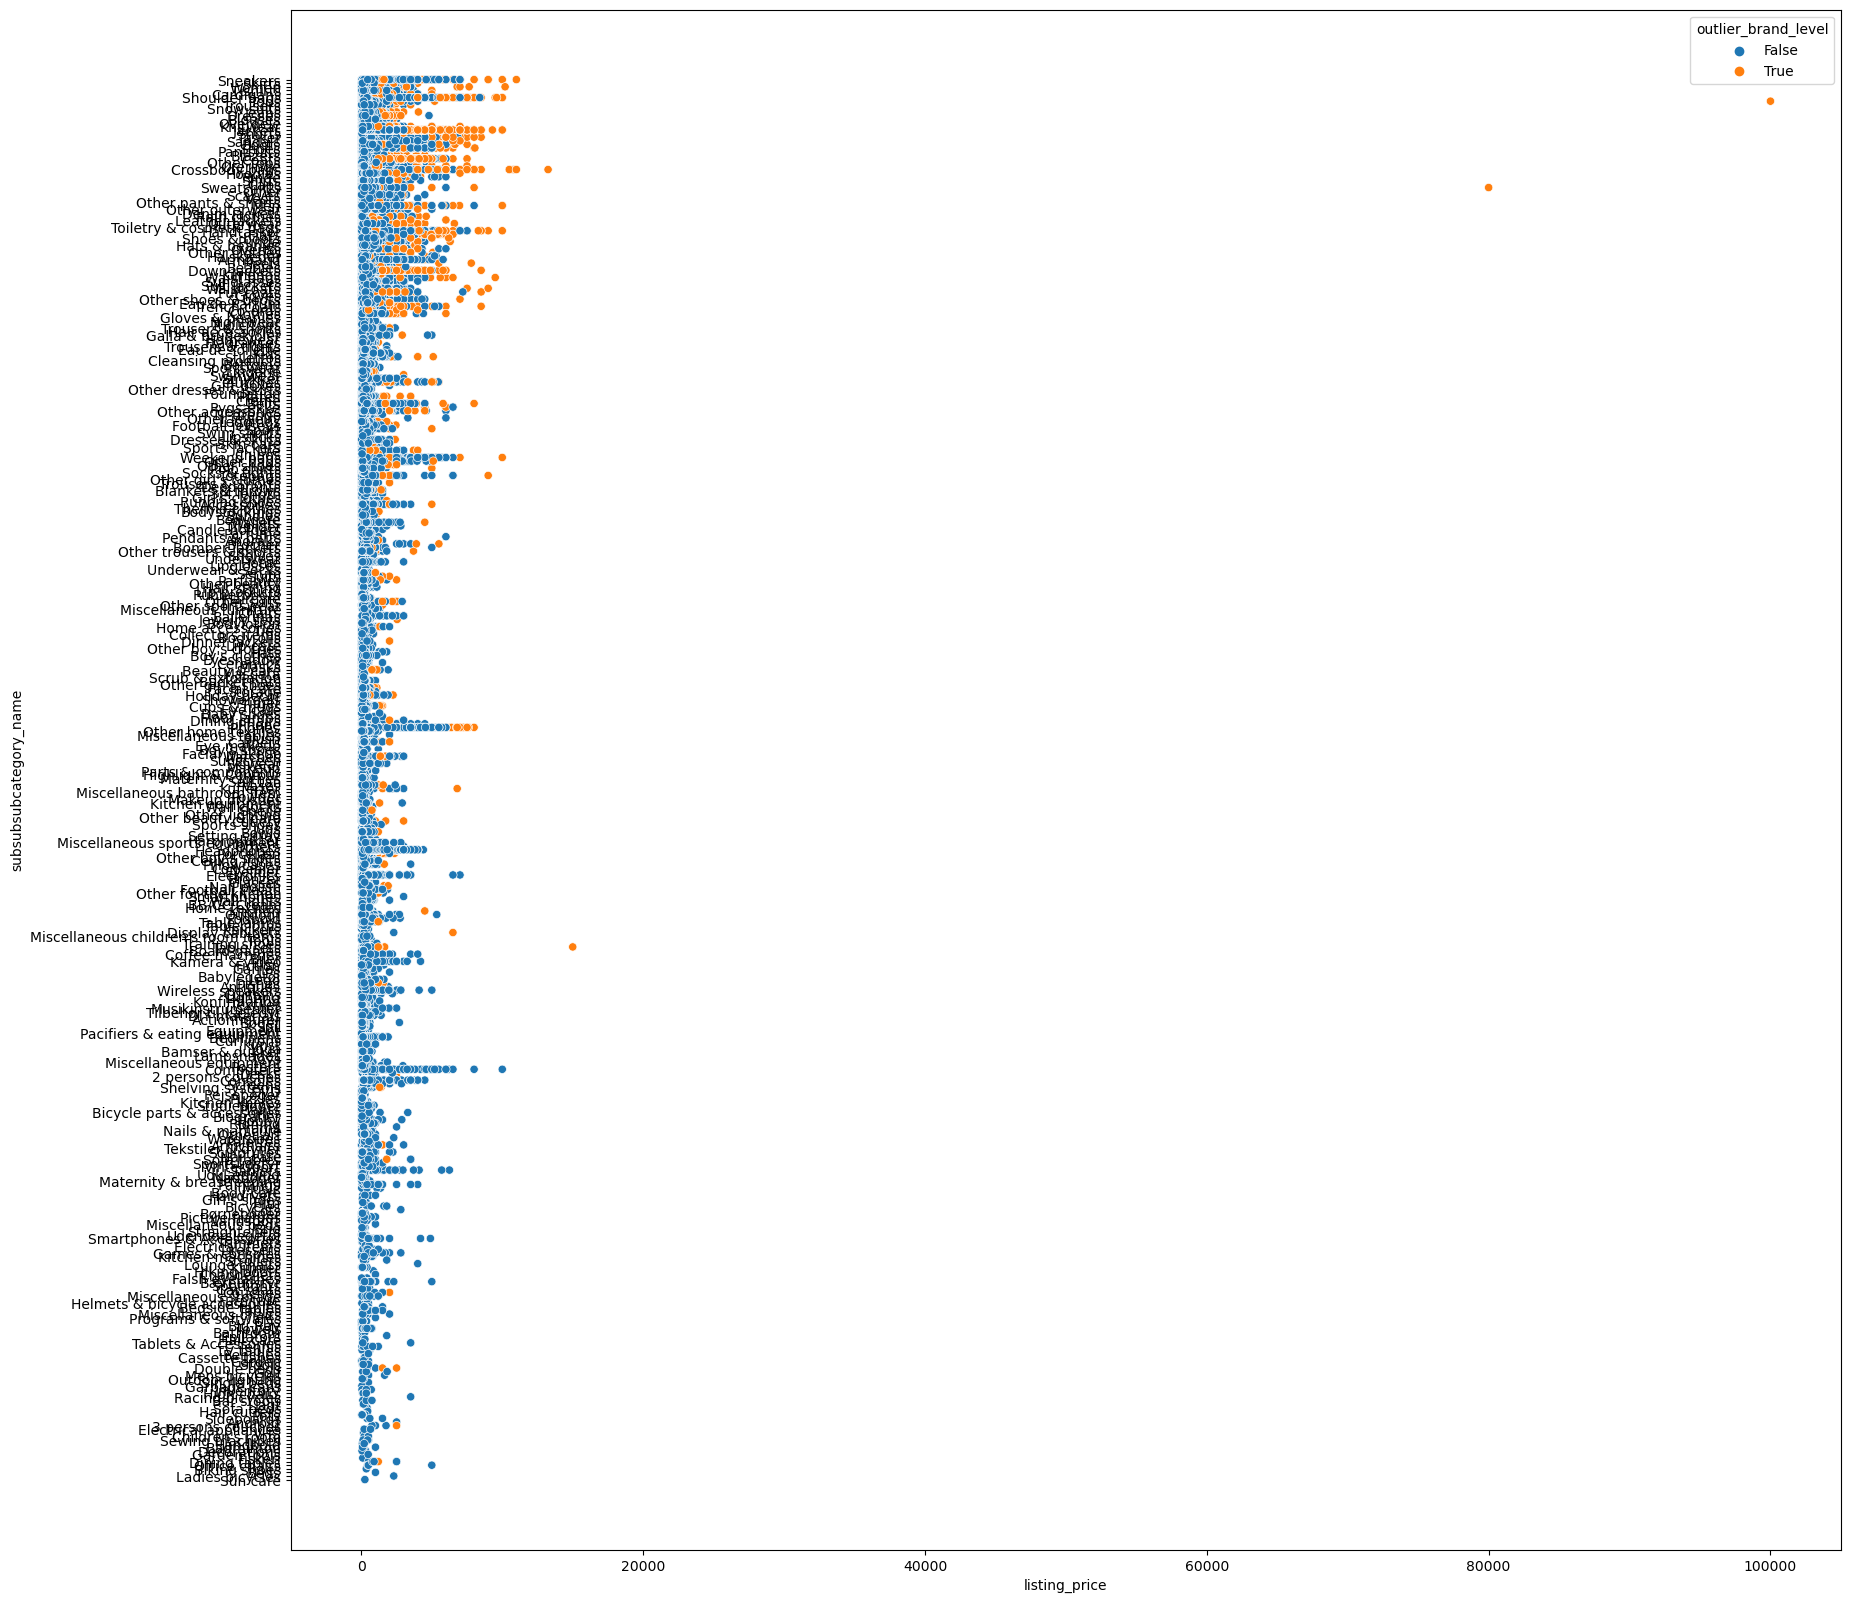

In [429]:
fig, axs = plt.subplots(figsize=(20,20))
#sns.scatterplot(data=df[df.brand_name.isin(df.brand_name.value_counts().head(100).index)], x='listing_price', y='subsubsubcategory_name', hue='outlier_brand_level')
sns.scatterplot(data=df, x='listing_price', y='subsubsubcategory_name', hue='outlier_brand_level')

# I want to ensure that the outliers predicted on a brand level also makes sense from a subsubsubsubcategoy_name level

### Gaussian Threshold
Compute brand gaussians and determine a probabilistic threshold where customers that lie outside of this are considered outliers. I.e. customers that are significantly far away from mean and std are outliers

In [538]:
# Function for computing gaussian pdf
def gaussian_pdf(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std)**2)

In [539]:
# Computing mean and standard devation on brand level
gauss = df.groupby('brand_name').agg(avg = ('listing_price', lambda x: x.mean()),
                                     std_dev = ('listing_price', lambda x: x.std())).reset_index()

# Merge with df
gauss_df = df.merge(gauss, on='brand_name', how='left')

# Computing pdf of each listing
gauss_df = gauss_df.assign(
    pdf = lambda x: gaussian_pdf(x.listing_price, x.avg, x.std_dev))

In [540]:
# Comparing pdfs for earlier detected outliers. I would expect that it would be negative values as the pdf of non-outliers should be higher
gauss_df[gauss_df.outlier_brand_level == True].pdf.describe() - gauss_df[gauss_df.outlier_brand_level == False].pdf.describe()

count   -2.409760e+05
mean    -1.355667e-03
std     -9.780030e-04
min     -3.346702e-08
25%     -6.316009e-04
50%     -1.114933e-03
75%     -1.820483e-03
max     -4.774276e-03
Name: pdf, dtype: float64

In [541]:
# Set threshold based on lower 5% quantile and upper 95%
gauss_df = gauss_df.merge(gauss_df.groupby('brand_name').agg(pdf98 = ('pdf', lambda x: x.quantile(.95)),
                                   pdf02 = ('pdf', lambda x: x.quantile(.05))).reset_index(), on='brand_name', how='left')

# Determine if pdf exceeds threshold
gauss_df['pdf_exceeds'] = (gauss_df.pdf > gauss_df.pdf98) | (gauss_df.pdf < gauss_df.pdf02)

In [542]:
# Explore brands
gauss_df[gauss_df.pdf_exceeds == True].brand_name.value_counts()

Adidas             879
Zara               779
Carhartt           666
Ganni              611
Nike               594
                  ... 
Soyaconcept          4
Britt Sisseck        4
Only Carmakoma       4
Oakley               3
Brandy Melville      3
Name: brand_name, Length: 419, dtype: int64

In [543]:
# Interestingly and quite nicely is that it's not only expensive brands but also popular ones

In [544]:
# Listing Price percentiles for Adidas outliers
gauss_df[(gauss_df.pdf_exceeds == True) & (gauss_df.brand_name == 'Adidas')].listing_price.describe(percentiles=percentiles)

count      879.000000
mean       710.724687
std        749.592631
min         15.000000
25%         55.000000
50%        750.000000
75%        795.000000
80%        799.000000
90%       1545.000000
99%       2296.100000
99.9%    10122.000000
max      11000.000000
Name: listing_price, dtype: float64

In [545]:
# Here we see some that over 50% of Adidads outliers are above 750, which is quite high price for Adidas products.

In [561]:
gauss_df[(gauss_df.pdf_exceeds == True) & (gauss_df.brand_name == 'Adidas')].sort_values(by='listing_price', ascending=False).sample(5)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,viewed_count_normalized,favourites_normalized,outlier,outlier_brand_level,avg,std_dev,pdf,pdf98,pdf02,pdf_exceeds
76623,31125809,2023-10-15,2077095,49,60,3,7,Adidas,Good but used,Blue,...,0.000644,0.009772,False,False,761.557317,498.486658,0.000297,0.000798,0.00031,True
84355,30695986,2023-09-24,329888,40,40,0,16,Adidas,Good but used,Light blue,...,0.001473,0.000000,False,False,761.557317,498.486658,0.000281,0.000798,0.00031,True
95475,30356405,2023-09-07,1994417,49,70,0,10,Adidas,Good but used,Black,...,0.000921,0.000000,False,False,761.557317,498.486658,0.000306,0.000798,0.00031,True
101829,30500239,2023-09-15,2277067,85,45,1,11,Adidas,Good but used,Grey,...,0.001013,0.003257,False,False,761.557317,498.486658,0.000285,0.000798,0.00031,True
111831,31596663,2023-11-07,376931,600,750,3,35,Adidas,Good but used,Grey,...,0.003222,0.009772,False,False,761.557317,498.486658,0.000800,0.000798,0.00031,True


In [549]:
top_10_brands = df.brand_name.value_counts().head(10).index
# Computing brand gaussians for visualization
x = np.linspace(0, 2000, 1000)
brand_gausses = {}
for o, y in gauss[gauss.brand_name.isin(list(top_10_brands) + expensive_brands)].iterrows():
    brand_gausses[y.brand_name] = np.array(gaussian_pdf(x, y.avg, y.std_dev))

In [559]:
# Generating pandas dataframe for easier plotting
gaussians_top_brands = pd.DataFrame([(brand, val, x[i]) for brand, values in brand_gausses.items() for i, val in enumerate(values)], columns=['Brand', 'Value', 'X'])
gaussians_top_brands.head()

,Brand,Value,X
0,Adidas,0.000249,0.000000
1,Adidas,0.000251,2.002002
2,Adidas,0.000252,4.004004
3,Adidas,0.000254,6.006006
4,Adidas,0.000255,8.008008


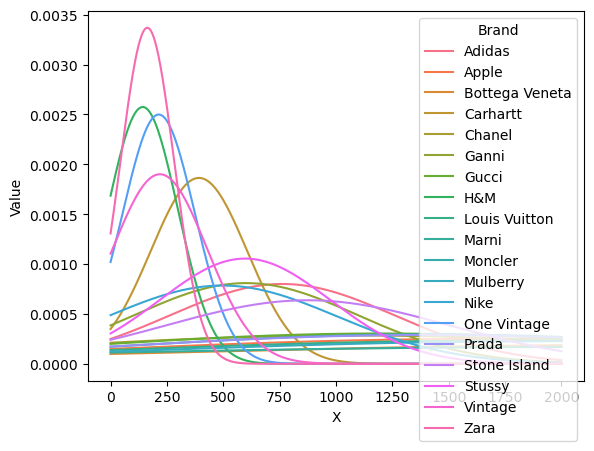

In [558]:
# Plotting Gaussians of top 10 brands + exepnsive brands
sns.lineplot(data=gaussians_top_brands, x='X', y='Value', hue='Brand')#, ax=axs)
axs.hlines(0.00002, xmin=0, xmax=100000)
plt.show()